In [4]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Import libraries
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import itertools
import argparse
import sys
import time
from sklearn import preprocessing
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import wget
import numpy as np

In [3]:
## Preprocessing of data
# Function to load data
def get_power_data():
    """
    Read the Individual household electric power consumption dataset
    """
    
    # Assume that the dataset is located on folder "data"
    # data = pd.read_csv('data/household_power_consumption.txt',
    #                    sep=';', low_memory=False)
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip"
    data = pd.read_csv(url, sep=";", low_memory=False, )
                    # parse_dates={"timestamp":["Date", "Time"]}, 
                    # infer_datetime_format=True, index_col="timestamp")
    
    # Drop some non-predictive variables
    data = data.drop(columns=['Date', 'Time'], axis=1)

    #print(data.head())

    # Replace missing values
    data = data.replace('?', np.nan)

    # Drop NA
    data = data.dropna(axis=0)

    # Normalize
    standard_scaler = preprocessing.StandardScaler()
    np_scaled = standard_scaler.fit_transform(data)
    data = pd.DataFrame(np_scaled)

    # Goal variable assumed to be the first
    X = data.values[:, 1:].astype('float32')
    y = data.values[:, 0].astype('float32')

    # Create categorical y for binary classification with balanced classes
    y = np.sign(y+0.46)

    # Split train and test data here: (X_train, Y_train, X_test, Y_test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    no_class = 2 #binary classification

    return X_train, X_test, y_train, y_test, no_class


In [4]:
X_train, X_test, y_train, y_test, no_class = get_power_data()
print("X,y types: {} {}".format(type(X_train), type(y_train)))
print("X size {}".format(X_train.shape))
print("y size {}".format(y_train.shape))

# Create a binary variable from one of the columns.
# You can use this OR not

idx = y_train >= 0
notidx = y_train < 0
y_train[idx] = 1
y_train[notidx] = -1

X,y types: <class 'numpy.ndarray'> <class 'numpy.ndarray'>
X size (1536960, 6)
y size (1536960,)


In [21]:
def get_greenhouse_data():
    '''
    Read the Greenhouse Gas Observing Network Data Set
        X : `numpy.array`, shape=(n_samples, n_features)
            The features matrix
        y : `numpy.array`, shape=(n_samples,)
            The vector of labels
    '''
    # url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00328/ghg_data.zip'
    # file_name = 'datasetGHG'
    # wget.download(url, file_name)
    # !unzip /content/datasetGHG

    N = 2921 # number of data 
    d = int(5232/16*15) # number of features
    count = ["%04d" % x for x in range(1, N+1)]
    X = np.zeros((N, d))
    avg = np.zeros(N)
    
    for n in range(1, N+1):
        datContent = [i.strip().split() for i in open("./ghg_data/ghg.gid.site{}.dat".format(count[n-1])).readlines()]
        X[n-1,:] = np.array(datContent[:15]).astype(float).reshape((-1))
        avg[n-1] = np.average(np.array(datContent[15]).astype(float))
    
    avgAll = np.average(avg)
    y = [-1 if avg[i]<avgAll else 1 for i in range(N)]
    y = np.array(y)
    
    print(X.shape)
    print(y.shape)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    no_class = 2 #binary classification

    return X_train, X_test, y_train, y_test, no_class

X_train, X_test, y_train, y_test, no_class = get_greenhouse_data()

(2921, 4905)
(2921,)


In [5]:
# Sigmoid function
def sigmoid(x, derivative=False):
    sigm = 1. / (1. + np.exp(-x))
    if derivative:
        return sigm * (1. - sigm)
    return sigm

# Define weights initialization
def initialize_w(N, d):
    return 2*np.random.random((N,d)) - 1

In [6]:
# Fill in feed forward propagation
def feed_forward_propagation(X, y, w_1, w_2, w_3, lmbda):
    # Fill in
    layer_0 = X.T # d*N
    layer_1 = sigmoid(np.dot(w_1.T, layer_0)) # w*d * d*N = w*N
    layer_2 = sigmoid(np.dot(w_2.T, layer_1)) # w*w * w*N = w*N
    layer_3 = np.dot(w_3.T, layer_2) # 1*w * w*N = 1*N
    
    return layer_0, layer_1, layer_2, layer_3
    
# Fill in backpropagation    
def back_propagation(y, w_1, w_2, w_3, layer_0, layer_1, layer_2, layer_3):
    # Calculate the gradient here
    # Compute the error
    layer_3_error = layer_3 - y.reshape(1,y.shape[0]) # 1*N
    layer_2_error = np.dot(w_3, layer_3_error) * layer_2 * (1 - layer_2) # w*N
    layer_1_error = np.dot(w_2, layer_2_error) * layer_1 * (1 - layer_1) # w*N
    
    # Compute the gradients of the weights
    layer_3_delta = np.dot(layer_2, layer_3_error.T) # w*1
    layer_2_delta = np.dot(layer_1, layer_2_error.T) # w*w
    layer_1_delta = np.dot(layer_0, layer_1_error.T) # d*w
    
    return layer_1_delta, layer_2_delta, layer_3_delta   

In [7]:
# Cost function
def costFunc(X, y, w_1, w_2, w_3, lmbda):
    N, d = X.shape
    a1,a2,a3,a4 = feed_forward_propagation(X,y,w_1,w_2,w_3,lmbda)
    # print('y_pred: ', a4[0,:])

    y_pred = a4[0,:]
    y_pred = np.sign(y_pred) # Convert to -1 and 1
    y_pred[y_pred == 0] = 1  # Assign 1 to zero predictions
    accuracy = np.mean(y_pred == y) * 100
    print('accuracy (%): ', accuracy)
    loss = np.linalg.norm(a4[0,:] - y,2) ** 2 / N
    
    return loss, accuracy


# Optimization Algorithms

In [8]:
def SGD(X, y, w_1, w_2, w_3, lmbda, learning_rate, batch_size=16):
    m = X.shape[0]
    n_batches = int(np.ceil(m / batch_size))
    
    for i in range(n_batches):
        # Split the shuffled data into batches of size batch_size.
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        X_batch = X[start_idx:end_idx, :]
        y_batch = y[start_idx:end_idx]
        
        layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X_batch, y_batch, w_1, w_2, w_3, lmbda)
        layer_1_delta, layer_2_delta, layer_3_delta = back_propagation(y_batch, w_1, w_2, w_3, layer_0, layer_1, layer_2, layer_3)
        
        # Update the weights using the gradients and learning rate.
        w_3 -= learning_rate * (layer_3_delta / batch_size + lmbda * w_3 / m)
        w_2 -= learning_rate * (layer_2_delta / batch_size + lmbda * w_2 / m)
        w_1 -= learning_rate * (layer_1_delta / batch_size + lmbda * w_1 / m)

        # # calculate current loss
        # # cost = costFunc(X_test, y_test, w_1, w_2, w_3, lmbda)
        # a1,a2,a3,a4 = feed_forward_propagation(X_test,y_test,w_1,w_2,w_3,lmbda)
        # cost = np.linalg.norm(a4[0,:] - y_test, 2) ** 2 / N
        # print("cost: ", cost)

    return w_1, w_2, w_3


In [9]:
def SVRG(X, y, w_1, w_2, w_3, lmbda, learning_rate):
    # Initialize weights
    w_tilde_1 = w_1
    w_tilde_2 = w_2
    w_tilde_3 = w_3
    m = X.shape[0]
    update_freq = m

    # Compute full gradients and save them
    layer_1_deltas, layer_2_deltas, layer_3_deltas = [], [], []
    perm = np.random.permutation(m)
    for i in range(update_freq):
        idx = perm[i]
        layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X[idx:idx+1], y[idx:idx+1], w_1, w_2, w_3, lmbda)
        full_layer_1_delta, full_layer_2_delta, full_layer_3_delta = back_propagation(y[idx:idx+1], w_1, w_2, w_3, layer_0, layer_1, layer_2, layer_3)
        layer_1_deltas.append(full_layer_1_delta)
        layer_2_deltas.append(full_layer_2_delta)
        layer_3_deltas.append(full_layer_3_delta)
    
    mu1 = np.mean(np.array(layer_1_deltas), axis=0)
    mu2 = np.mean(np.array(layer_2_deltas), axis=0)
    mu3 = np.mean(np.array(layer_3_deltas), axis=0)
    
    # # SVRG loop
    # Select a random subset of the data for the epoch
    for i in range(int(update_freq/10)):
        # Select a random batch of data
        idx = perm[i]
        X_batch = X[idx:idx+1,:]
        y_batch = y[idx:idx+1]
        
        # Compute the gradients on the current batch using the current weights
        layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X_batch, y_batch, w_tilde_1, w_tilde_2, w_tilde_3, lmbda)
        layer_1_delta, layer_2_delta, layer_3_delta = back_propagation(y_batch, w_tilde_1, w_tilde_2, w_tilde_3, layer_0, layer_1, layer_2, layer_3)
        
        # Compute the gradients on the current batch using the saved weights
        full_layer_0, full_layer_1, full_layer_2, full_layer_3 = feed_forward_propagation(X_batch, y_batch, w_1, w_2, w_3, lmbda)
        w_layer_1_delta, w_layer_2_delta, w_layer_3_delta = back_propagation(y_batch, w_1, w_2, w_3, full_layer_0, full_layer_1, full_layer_2, full_layer_3)
        
        # Compute the update to the tilde weights
        delta_w_tilde_3 = layer_3_delta - layer_3_deltas[i] + mu3
        delta_w_tilde_2 = layer_2_delta - layer_2_deltas[i] + mu2
        delta_w_tilde_1 = layer_1_delta - layer_1_deltas[i] + mu1
        
        # Update the tilde weights
        w_tilde_3 -= learning_rate * (delta_w_tilde_3 + lmbda * w_tilde_3 / m)
        w_tilde_2 -= learning_rate * (delta_w_tilde_2 + lmbda * w_tilde_2 / m)
        w_tilde_1 -= learning_rate * (delta_w_tilde_1 + lmbda * w_tilde_1 / m)
        
    # Update the weights at the end of the epoch
    w_3 = w_tilde_3
    w_2 = w_tilde_2
    w_1 = w_tilde_1
    
    return w_1, w_2, w_3

In [10]:
def GD(X, y, w_1, w_2, w_3, lmbda, learning_rate):
    m = X.shape[0]
    layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X, y, w_1, w_2, w_3, lmbda)
    layer_1_delta, layer_2_delta, layer_3_delta = back_propagation(y, w_1, w_2, w_3, layer_0, layer_1, layer_2, layer_3)
    
    # Update the weights using the gradients and learning rate.
    w_3 -= learning_rate * (layer_3_delta + lmbda * w_3 / m)
    w_2 -= learning_rate * (layer_2_delta + lmbda * w_2 / m)
    w_1 -= learning_rate * (layer_1_delta + lmbda * w_1 / m)

    return w_1, w_2, w_3


In [11]:
# Define perturbed GD here:
def PGD(X, y, w_1, w_2, w_3, learning_rate, lmbda, noise):
    # Initialize weights
    m = X.shape[0]
    
    # Compute gradients
    layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X, y, w_1, w_2, w_3, lmbda)
    layer_1_delta, layer_2_delta, layer_3_delta = back_propagation(y, w_1, w_2, w_3, layer_0, layer_1, layer_2, layer_3)
    
    # Add noise to the gradients
    layer_1_delta += noise * np.random.randn(*layer_1_delta.shape)
    layer_2_delta += noise * np.random.randn(*layer_2_delta.shape)
    layer_3_delta += noise * np.random.randn(*layer_3_delta.shape)
    
    # Update weights
    w_3 -= learning_rate * (layer_3_delta + lmbda * w_3 / m)
    w_2 -= learning_rate * (layer_2_delta + lmbda * w_2 / m)
    w_1 -= learning_rate * (layer_1_delta + lmbda * w_1 / m)
    return w_1, w_2, w_3


In [12]:
def BCD(X, y, w_1, w_2, w_3, learning_rate, lmbda):
    m = X.shape[0]
    block_size = m // 3
    w_old = [w_1, w_2, w_3]

    # Shuffle data
    perm = np.random.permutation(m)
    X = X[perm]
    y = y[perm]

    # Update each block of weights
    for j in range(3):
        start = j * block_size
        end = (j + 1) * block_size

        # Get subset of data and labels
        X_block = X[start:end]
        y_block = y[start:end]

        # Compute gradients for the block
        layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X_block, y_block, w_old[0], w_old[1], w_old[2], lmbda)
        layer_1_delta, layer_2_delta, layer_3_delta = back_propagation(y_block, w_old[0], w_old[1], w_old[2], layer_0, layer_1, layer_2, layer_3)

        # Update weights for the block
        if j == 0:
            w_old[0] -= learning_rate * (layer_1_delta + lmbda * w_old[0])
        elif j == 1:
            w_old[1] -= learning_rate * (layer_2_delta + lmbda * w_old[1])
        else:
            w_old[2] -= learning_rate * (layer_3_delta + lmbda * w_old[2])

    return w_old[0], w_old[1], w_old[2]

# Training & Test

In [58]:
# Should be a hyperparameter that you tune, not an argument - Fill in the values
parser = argparse.ArgumentParser()

# Power
# parser.add_argument('--lambda', type=float, default=1e-5, dest='lmbda') 
# parser.add_argument('--w_size', type=int, default=25, dest='w_size')
# parser.add_argument('--lr', type=float, default=1e-7)
# parser.add_argument('--iterations', type=int, default=30)

# GHG
parser = argparse.ArgumentParser()
parser.add_argument('--lambda', type=float, default=1e-4, dest='lmbda') 
parser.add_argument('--w_size', type=int, default=50, dest='w_size')
parser.add_argument('--lr', type=float, default=1e-5)
parser.add_argument('--iterations', type=int, default=250)
args = parser.parse_args([])


In [59]:
# Define the optimizers for the loop
# # Power
# def defineOptimizer(i, X_train, y_train, w_1, w_2, w_3, lmbda, lr, batch_size=16):
#     if i == 0:
#         optimizers = {# Fill in the hyperparameters
#                         "opt": SGD(X_train, y_train, w_1, w_2, w_3, lmbda, lr*1e3, batch_size),
#                         "name": "SGD",
#                      }
#     elif i == 1:
#         optimizers = {# Fill in the hyperparameters
#                         "opt": SVRG(X_train, y_train, w_1, w_2, w_3, lmbda, lr*1e3),
#                         "name": "SVRG",
#                     }
#     elif i == 2:
#         optimizers = {# Fill in the hyperparameters
#                         "opt": GD(X_train, y_train, w_1, w_2, w_3, learning_rate=lr, lmbda=lmbda),
#                         "name": "GD",
#                      }       
#     elif i == 3:
#         optimizers = {# Fill in the hyperparameters
#                         "opt": PGD(X_train, y_train, w_1, w_2, w_3, learning_rate=lr, lmbda=lmbda, noise=1e-3),
#                         "name": "PGD",
#                     }
#     elif i == 4:
#         optimizers = {# Fill in the hyperparameters
#                         "opt": BCD(X_train, y_train, w_1, w_2, w_3, learning_rate=lr, lmbda=lmbda),
#                         "name": "BCD",
#                     }
#     return optimizers

# GHG
def defineOptimizer(i, X_train, y_train, w_1, w_2, w_3, lmbda, lr, batch_size=16):
    if i == 0:
        optimizers = {# Fill in the hyperparameters
                        "opt": SGD(X_train, y_train, w_1, w_2, w_3, lmbda, lr*1e1, batch_size),
                        "name": "SGD",
                     }
    elif i == 1:
        optimizers = {# Fill in the hyperparameters
                        "opt": SVRG(X_train, y_train, w_1, w_2, w_3, lmbda, lr*4e1),
                        "name": "SVRG",
                    }
    elif i == 2:
        optimizers = {# Fill in the hyperparameters
                        "opt": GD(X_train, y_train, w_1, w_2, w_3, learning_rate=lr, lmbda=lmbda),
                        "name": "GD",
                     }       
    elif i == 3:
        optimizers = {# Fill in the hyperparameters
                        "opt": PGD(X_train, y_train, w_1, w_2, w_3, learning_rate=lr, lmbda=lmbda, noise=1e-3),
                        "name": "PGD",
                    }
    elif i == 4:
        optimizers = {# Fill in the hyperparameters
                        "opt": BCD(X_train, y_train, w_1, w_2, w_3, learning_rate=lr, lmbda=lmbda),
                        "name": "BCD",
                    }
    return optimizers

In [60]:
# Run the iterates over the algorithms above
lossTrain = []
lossTest = []
accTrain = []
accTest = []
algoNames = ['SGD', 'SVRG', 'GD', 'PGD', 'BCD']

for i in range(5):
    print("Running {}".format(algoNames[i]))
    w_size = args.w_size
    if i == 1:
        w_size = int(args.w_size / 2)
    w_1 = initialize_w(X_train.shape[1], w_size)
    w_2 = initialize_w(w_size,w_size)
    w_3 = initialize_w(w_size, 1)

    lossTrainAlg = []
    accTrainAlg = []

    iterNum = args.iterations
    if i == 1:
        iterNum = int(args.iterations / 2)
    for j in range(iterNum):
        optimizers = defineOptimizer(i, X_train, y_train, w_1, w_2, w_3, args.lmbda, args.lr)
        w_1, w_2, w_3 = optimizers["opt"]
        lossTrainPer, accTrainPer = costFunc(X_train, y_train, w_1, w_2, w_3, args.lmbda)

        lossTrainAlg.append(lossTrainPer)
        accTrainAlg.append(accTrainPer)
        print('train loss in {}, iter {}: {}'.format(algoNames[i], j, lossTrainPer))
        
    lossTrain.append(lossTrainAlg)
    accTrain.append(accTrainAlg)

    lossTestAlg, accuracy = costFunc(X_test, y_test, w_1, w_2, w_3, args.lmbda)
    lossTest.append(lossTestAlg)
    accTest.append(accuracy)
    print('test loss in {}: {}, accuracy: {}\n'.format(algoNames[i], lossTestAlg, accuracy))
    

Running SGD


C:\Users\Yifei\AppData\Local\Temp\ipykernel_13376\245564508.py:3: RuntimeWarning: overflow encountered in exp
  sigm = 1. / (1. + np.exp(-x))


accuracy (%):  45.47945205479452
train loss in SGD, iter 0: 2.7136183757726204
accuracy (%):  45.52511415525114
train loss in SGD, iter 1: 2.6523463593986523
accuracy (%):  45.38812785388128
train loss in SGD, iter 2: 2.6042294476501557
accuracy (%):  45.15981735159818
train loss in SGD, iter 3: 2.559410779879826
accuracy (%):  45.02283105022831
train loss in SGD, iter 4: 2.518074242533079
accuracy (%):  45.20547945205479
train loss in SGD, iter 5: 2.478716373322072
accuracy (%):  45.20547945205479
train loss in SGD, iter 6: 2.44067243897432
accuracy (%):  45.25114155251141
train loss in SGD, iter 7: 2.3995782890714135
accuracy (%):  45.34246575342466
train loss in SGD, iter 8: 2.3613261890876522
accuracy (%):  45.662100456621005
train loss in SGD, iter 9: 2.327920513439694
accuracy (%):  45.84474885844749
train loss in SGD, iter 10: 2.295040944445952
accuracy (%):  45.98173515981735
train loss in SGD, iter 11: 2.2632833661813705
accuracy (%):  46.118721461187214
train loss in SGD, ite

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


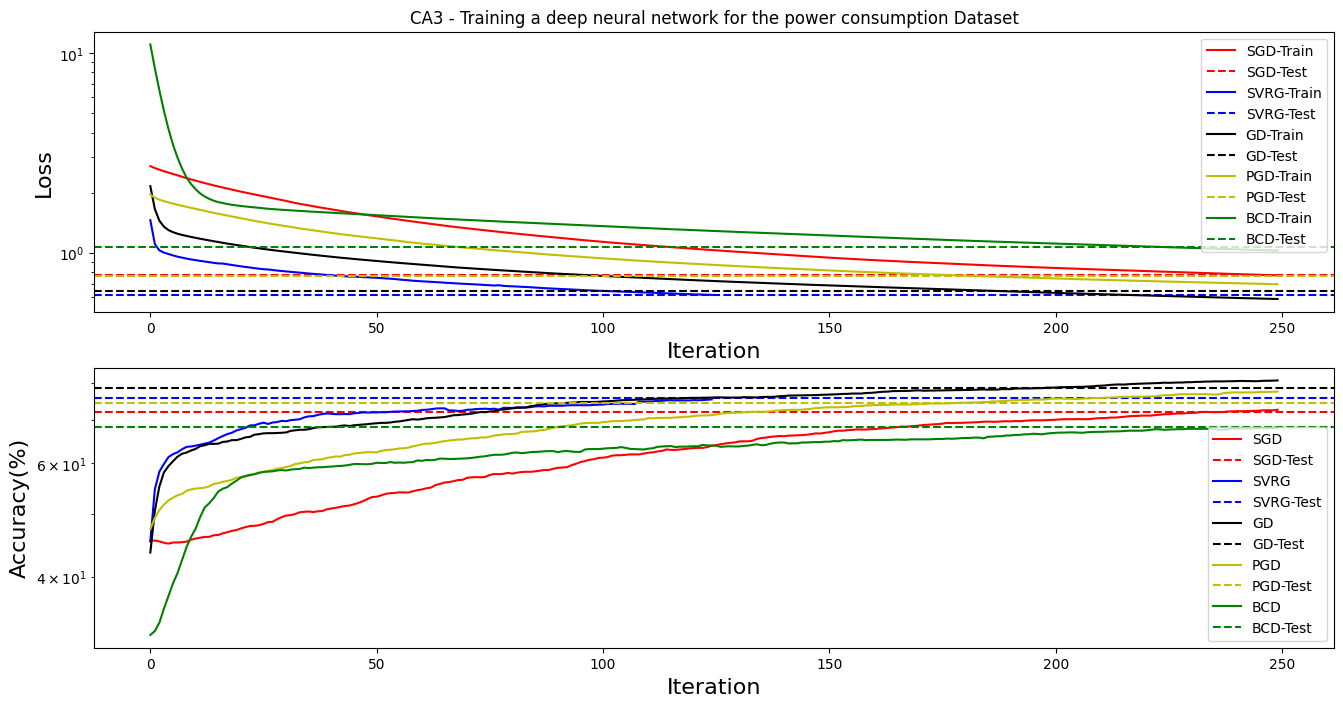

In [61]:
# Plot results
fig, ax = plt.subplots(2, 1, figsize=(16, 8))
colors = ['r', 'b', 'k', 'y', 'g']

ax[0].legend(loc="upper right")
ax[0].set_xlabel(r"Iteration", fontsize=16)
ax[0].set_ylabel("Loss", fontsize=16)
ax[0].set_title("CA3 - Training a deep neural network for the power consumption Dataset")
# ax[0].set_ylim(ymin=0, ymax=2)
ax[0].set_yscale('log')

for i in range(len(lossTrain)):
    ax[0].plot(lossTrain[i], color=colors[i], label='{}-Train'.format(algoNames[i]))
    ax[0].axhline(y=lossTest[i], linestyle='--', color=colors[i], label='{}-Test'.format(algoNames[i]))
ax[0].legend()

ax[1].legend(loc="upper right")
ax[1].set_xlabel(r"Iteration", fontsize=16)
ax[1].set_ylabel("Accuracy(%)", fontsize=16)
# ax[1].set_ylim(ymin=50, ymax=100)
ax[1].set_yscale('log')
ax[1].plot()

for i in range(len(accTrain)):
    ax[1].plot(accTrain[i], color=colors[i], label=algoNames[i])
    ax[1].axhline(y=accTest[i], linestyle='--', color=colors[i], label='{}-Test'.format(algoNames[i]))
ax[1].legend()

# plt.savefig("power.png")
plt.savefig("GHG.png")